# Laporan Proyek 2

## Prediksi Harga Minyak Per-Minggu Menggunakan Data Historis Time Series

## Pendahuluan

## Latar Belakang
Harga minyak goreng merupakan salah satu faktor penting dalam sektor rumah tangga dan industri makanan. Perubahan harga yang tidak menentu dapat memengaruhi daya beli masyarakat, biaya produksi, serta stabilitas pasar. Oleh karena itu, diperlukan model prediksi yang mampu membantu mengantisipasi perubahan harga minyak goreng.

## Tujuan Proyek
Proyek ini bertujuan untuk membangun model prediksi berbasis data historis time series yang dapat menghasilkan estimasi harga minyak goreng secara akurat. Model ini diharapkan mampu:

- Mendukung para pelaku usaha, pemerintah, dan konsumen dalam merencanakan keputusan terkait pembelian, distribusi, maupun stok minyak goreng.
- Menyediakan panduan strategis untuk merancang kebijakan yang bertujuan menjaga kestabilan harga minyak goreng di pasar.

## Rumusan Masalah
- Apa saja langkah yang diperlukan untuk mengembangkan model prediksi harga minyak goreng dengan tingkat akurasi yang tinggi?
- Bagaimana prediksi harga minyak goreng dapat dimanfaatkan untuk mendukung pengambilan keputusan yang lebih strategis dan meminimalkan dampak negatif perubahan harga?

## Metodologi

## Data Understanding
a. Sumber Data 
Data yang digunakan dalam proyek ini diperoleh dari situs Pusat Informasi Harga Pangan Strategis Nasional https://www.bi.go.id/hargapangan/TabelHarga/PasarTradisionalDaerah. Situs ini menyediakan informasi harga bahan pangan, termasuk harga minyak goreng, berdasarkan wilayah di Indonesia.

Dalam proyek ini, data historis harga minyak goreng dari berbagai daerah dikumpulkan untuk periode tertentu. Data tersebut telah diunduh dalam format xlsx yang digunakan mulai dari tanggal 01 Januari 2020 hingga 25 September 2024. Data ini menjadi dasar untuk mengembangkan model prediksi berbasis metode machine learning guna memahami tren harga minyak goreng di berbagai wilayah.

Tampilan dari data harga minyak:

## Project

## Read Data

In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: seaborn in c:\laragon\bin\python\python-3.10\lib\site-packages (0.13.2)




[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


With MyST Markdown, you can define code cells with a directive like so:

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#Mengambil dan menampilkan data
df = pd.read_csv('https://raw.githubusercontent.com/windaafitri/dataset/refs/heads/main/harga_minyak.csv')
df

,Tanggal,Harga
0,01/ 01/ 2020,"15,550"
1,08/ 01/ 2020,"15,500"
2,15/ 01/ 2020,"15,550"
3,22/ 01/ 2020,"15,600"
4,29/ 01/ 2020,"15,650"
...,...,...
243,28/ 08/ 2024,"21,100"
244,04/ 09/ 2024,"21,350"
245,11/ 09/ 2024,"21,300"
246,18/ 09/ 2024,"21,300"


b. Deskripsi Dataset
- Jumlah Fitur dan baris data:

Dataset terdiri dari 2 fitur atau kolom dan 249 baris data.

- Atribut dalam dataset:

Tanggal: Kolom ini mencatat tanggal pengamatan harga minyak goreng dan menggunakan format seperti DD/MM/YYYY
Harga: Kolom ini mencatat harga minyak goreng pada tanggal tertentu.

In [3]:
# Pastikan kolom 'Date' dalam format datetime dengan dayfirst=True
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, errors='coerce')

# Mengatur kolom 'Date' sebagai indeks
df.set_index('Tanggal', inplace=True)

# Menghapus spasi dari kolom 'Harga', mengganti '-' dengan NaN, dan mengubahnya menjadi numeric
df['Harga'] = df['Harga'].replace('-', np.nan).str.replace(',', '').astype(float)

# Menampilkan 5 baris pertama untuk memastikan
print(df.head())

              Harga
Tanggal            
2020-01-01  15550.0
2020-01-08  15500.0
2020-01-15  15550.0
2020-01-22  15600.0
2020-01-29  15650.0


<Axes: xlabel='Tanggal'>

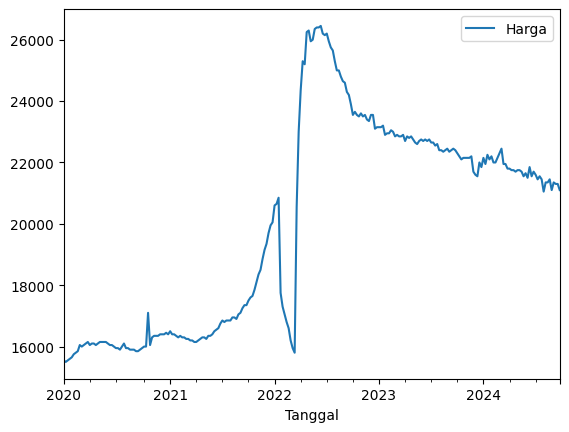

In [4]:
df.plot()

In [5]:
df.info()
print('Ukuran data ', df.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2020-01-01 to 2024-09-25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Harga   248 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
Ukuran data  (248, 1)


In [6]:
df.dtypes

Harga    float64
dtype: object

## Eksplorasi Data

In [7]:
# Mencari Missing Value
df.isnull().sum()

Harga    0
dtype: int64

In [8]:
# Deskripsi Statistik
df.describe()

,Harga
count,248.000000
mean,20019.153226
std,3397.558973
min,15500.000000
25%,16350.000000
50%,21350.000000
75%,22700.000000
max,26450.000000


## Preprocessing Data

## Sliding Windows
Di sini dilakukan proses sliding windows dengan tujuan untuk menambah fitur dari nilai historis kurs(lag) ke dalam dataset.

In [9]:
def create_lag_features(df, column_name, num_lags):

    # Buat fitur lag untuk jumlah lag yang diinginkan
    for lag in range(1, num_lags + 1):
        df[f'{column_name}-{lag}'] = df[column_name].shift(lag)

    # Hapus baris yang memiliki nilai NaN setelah pembuatan lag
    df.dropna(inplace=True)

    # Mengatur ulang kolom sehingga kolom asli berada di posisi terakhir
    lag_columns = [f'{column_name}-{lag}' for lag in range(num_lags, 0, -1)] + [column_name]
    df = df[lag_columns]

    return df

# Contoh penggunaan
num_lags = 4  # Tentukan berapa banyak lag yang diinginkan
df_lagged = create_lag_features(df, 'Harga', num_lags)

# Menampilkan 5 baris pertama untuk memastikan fitur lag telah ditambahkan
df_lagged.head()

,Harga-4,Harga-3,Harga-2,Harga-1,Harga
Tanggal,,,,,
2020-01-29,15550.0,15500.0,15550.0,15600.0,15650.0
2020-02-05,15500.0,15550.0,15600.0,15650.0,15750.0
2020-02-12,15550.0,15600.0,15650.0,15750.0,15800.0
2020-02-19,15600.0,15650.0,15750.0,15800.0,15850.0
2020-02-26,15650.0,15750.0,15800.0,15850.0,16050.0


## Normalisasi Data

In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Fungsi untuk membuat fitur lag secara dinamis
def create_lag_features(df, column_name, num_lags):

    # Buat fitur lag untuk jumlah lag yang diinginkan
    for lag in range(1, num_lags + 1):
        df[f'{column_name}-{lag}'] = df[column_name].shift(lag)

    # Hapus baris yang memiliki nilai NaN setelah pembuatan lag
    df.dropna(inplace=True)

    # Mengatur ulang kolom sehingga kolom asli berada di posisi terakhir
    lag_columns = [f'{column_name}-{lag}' for lag in range(num_lags, 0, -1)] + [column_name]
    df = df[lag_columns]

    return df

# Tentukan jumlah lag
num_lags = 4

# Membuat fitur lag dinamis
df_lagged = create_lag_features(df, 'Harga', num_lags)

# Inisialisasi scaler untuk fitur (input) dan target (output)
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Normalisasi fitur (Harga-1, Harga-2, ..., Harga-n)
df_features_normalized = pd.DataFrame(scaler_features.fit_transform(df_lagged.iloc[:, :-1]),
                                      columns=df_lagged.columns[:-1],
                                      index=df_lagged.index)

# Normalisasi target (Harga)
df_target_normalized = pd.DataFrame(scaler_target.fit_transform(df_lagged[['Harga']]),
                                    columns=['Harga'],
                                    index=df_lagged.index)

# Gabungkan kembali dataframe yang sudah dinormalisasi
df_normalized = pd.concat([df_features_normalized, df_target_normalized], axis=1)

# Tampilkan 5 baris pertama dari dataframe yang sudah dinormalisasi
df_normalized.head()

,Harga-4,Harga-3,Harga-2,Harga-1,Harga
Tanggal,,,,,
2020-02-26,0.000000,0.000000,0.000000,0.004695,0.023474
2020-03-04,0.009259,0.004673,0.004695,0.023474,0.018779
2020-03-11,0.013889,0.009346,0.023474,0.018779,0.023474
2020-03-18,0.018519,0.028037,0.018779,0.023474,0.028169
2020-03-25,0.037037,0.023364,0.023474,0.028169,0.032864


## Modelling
Menjelaskan proses apa saja yang akan diproses berdasarkan data yang sudah ada.

a. Pembagian Data
Dataset dibagi menjadi dua bagian utama: data pelatihan, yang digunakan untuk melatih model, dan data pengujian, yang digunakan untuk mengevaluasi kinerja model.

b. Pembangunan Model
Pada penelitian ini, dilakukan eksperimen menggunakan tiga model ditambah dengan ensemble Bagging, yaitu JST (Jaringan Syaraf Tiruan), SVR (Support Vector Regression), dan KNN (K-Nearest Neighbors).

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# List model untuk ensemble Bagging
models = {
    "Neural Network (JST)": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=32),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

# Dictionary untuk menyimpan hasil evaluasi
results = {}

# Iterasi setiap model
for i, (name, base_model) in enumerate(models.items()):
    # Inisialisasi Bagging Regressor
    bagging_model = BaggingRegressor(
        estimator=base_model,
        n_estimators=10,
        max_samples=0.7,
        random_state=32,
        bootstrap=True
    )

    # Latih model
    bagging_model.fit(X_train, y_train)

    # Prediksi pada data uji
    y_pred = bagging_model.predict(X_test)

    # Evaluasi
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Dalam persen

    # Simpan hasil evaluasi
    results[name] = {"RMSE": rmse, "MAPE": mape}

    # Kembalikan hasil prediksi ke skala asli
    y_pred_original = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
    y_test_original = scaler_target.inverse_transform(y_test.values.reshape(-1, 1))

    # Plot hasil prediksi
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test_original, label="Actual", color="blue")
    plt.plot(y_test.index, y_pred_original, label=f"Predicted ({name})", color="red")

    # Tambahkan detail plot
    plt.title(f'Actual vs Predicted Values ({name})')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)

    # Tampilkan plot
    plt.show()

# Tampilkan hasil evaluasi
for model, metrics in results.items():
    print(f"{model}:\n  RMSE: {metrics['RMSE']:.2f}\n  MAPE: {metrics['MAPE']:.2f}%\n")

NameError: name 'X_train' is not defined